In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage
from skimage.color import rgb2gray,gray2rgb
from sklearn.decomposition import PCA

# importing images

In [2]:
image1 = cv2.imread("rahmati-zareiyan-base.jpg")
image2 = cv2.imread("segmented.png")

# preprocessing data
<ul>
    <li>Convert BGR to RGB</li>
    <li>Plotting red,blue,green data</li>
    <li>Make img blur(median blur) for test1</li>
</ul>

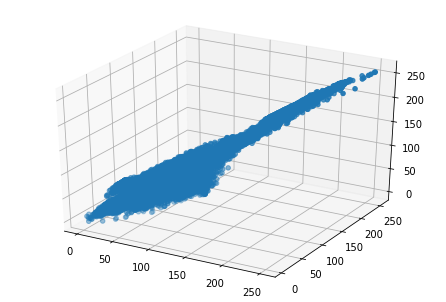

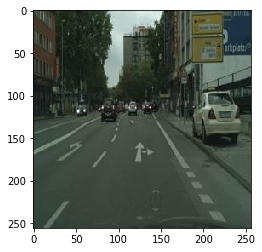

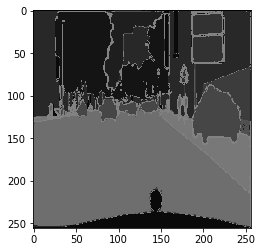

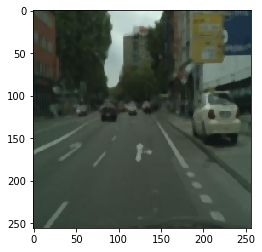

In [3]:
image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
base = image[:,:256,:]
gray = rgb2gray(image)
ground_truth = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)#image[:,256:512,:]
r, g, b = cv2.split(base)
r = r.flatten()
g = g.flatten()
b = b.flatten()#plotting 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()
plt.imshow(base)
plt.show()
plt.imshow(ground_truth)
plt.show()


#median blur
test1=cv2.medianBlur(base,5)
plt.imshow(test1)
plt.show()
# test2 = cv2.blur(base,(5,5))
# test3 = cv2.GaussianBlur(base,(5,5),0)
# test4 = cv2.bilateralFilter(base,9,75,75)
# plt.imshow(test2)
# plt.show()
# plt.imshow(test3)
# plt.show()
# plt.imshow(test4)
# plt.show()


<h2> Create mask for gray color</h2>
<p>changing light gray to dark gray</p>

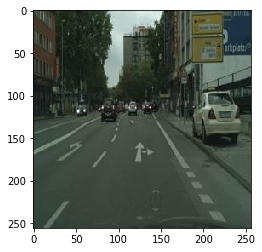

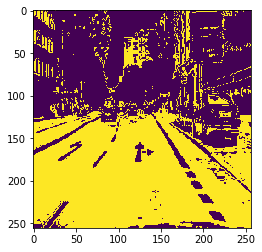

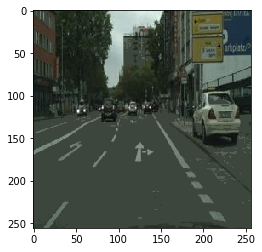

In [4]:
light_gray=(50,60,50)
dark_gray=(80,95,85)
result=base
plt.imshow(result)
plt.show()
mask = cv2.inRange(result, light_gray, dark_gray)
plt.imshow(mask)
plt.show()

for i in range(256):
    for j in range(256):
        if mask[i][j] == 255:
            result[i][j]=[60,70,60]

plt.imshow(result)
plt.show()

<h2>Create standard data for K-means</h2>

In [5]:
# reshape the image to a 2D array of pixels and 3 color values (RGB)
print(base.shape)
pixel_values = base.reshape((-1, 3))
print(pixel_values.shape)
# convert to float
pixel_values = np.float32(pixel_values)

print(test1.shape)
pixel_values1 = test1.reshape((-1, 3))
print(pixel_values1.shape)
# convert to float
pixel_values1 = np.float32(pixel_values1)



(256, 256, 3)
(65536, 3)
(256, 256, 3)
(65536, 3)


<h2>Kmeans criteria:</h2>
<ol>
    <li>number of iteration = 10000</li>
    <li>epsilon = 0.001</li>
</ol>

In [7]:

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.001)


<h2>Creating ellbow plot</h2>
<ol>
    <li>number of attempts = 20 : means run kmeans with 20 different initial points</li>
    <li>run kmeans with k clusters</li>
    <li>plot clusters error for 1 to k cluster</li>
</ol>

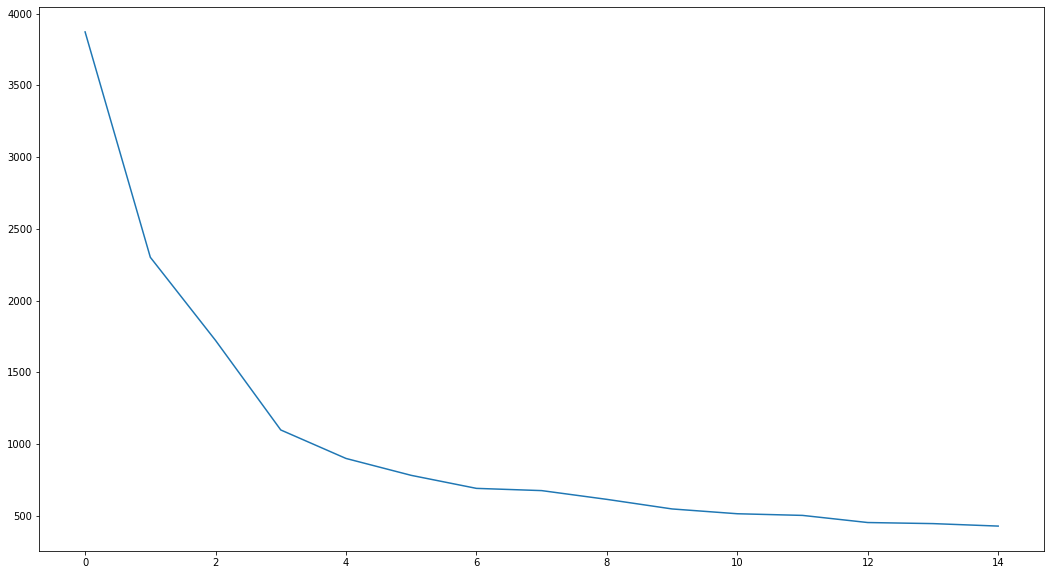

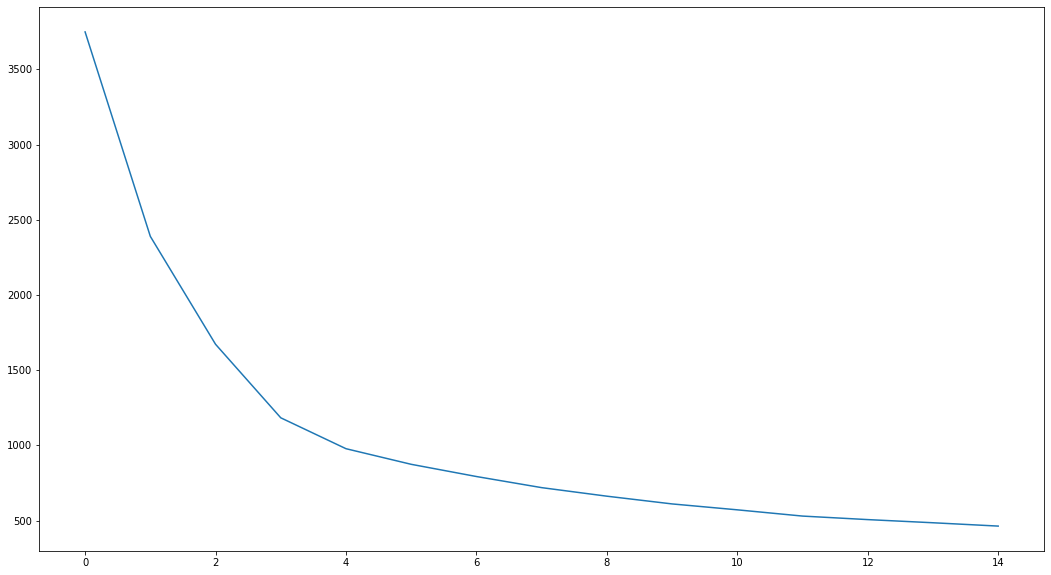

In [8]:
a = []
attempts = 20
for k in range(15):
    _, labels, (centers) = cv2.kmeans(pixel_values, k+1, None, criteria, attempts,cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    labels = labels.flatten()
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(base.shape)
    temp = cv2.norm(segmented_image, base)
    #what does it do? and for what?
    avg = cv2.mean(temp)
    a.append(avg[0])
plt.figure(figsize=(18, 10))
plt.plot(a)
plt.show()

a = []
for k in range(15):
    _, labels1, (centers1) = cv2.kmeans(pixel_values1, k+1, None, criteria, attempts,cv2.KMEANS_RANDOM_CENTERS)
    centers1 = np.uint8(centers1)
    labels1 = labels1.flatten()
    segmented_image1 = centers1[labels1.flatten()]
    segmented_image1 = segmented_image1.reshape(test1.shape)
    temp = cv2.norm(segmented_image1, test1)
    #what does it do? and for what?
    avg = cv2.mean(temp)
    a.append(avg[0])
plt.figure(figsize=(18, 10))
plt.plot(a)
plt.show()



<h2>choosing best K for number of clusters : 6</h2>

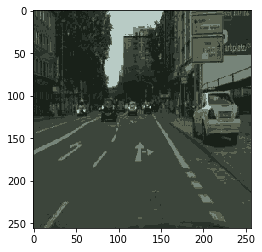

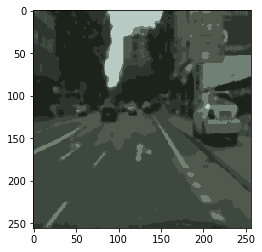

In [9]:
k = 6
attempts = 20
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
# centers=[
#     [0,256,256],
#     [256,0,0],
#     [0,256,0],
#     [0,0,256],
#     [100,180,180],
#     [180,100,180],
#     [180,180,100],
#     [50,100,100],
#     [100,100,50],
#     [100,50,100]
# ]
centers = np.uint8(centers)
labels = labels.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(base.shape)
plt.imshow(segmented_image)
plt.show()


# k = 6
# attempts = 10
_, labels1, (centers1) = cv2.kmeans(pixel_values1, k, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
# centers1=[
#     [0,256,256],
#     [256,0,0],
#     [0,256,0],
#     [0,0,256],
#     [100,180,180],
#     [180,100,180],
#     [180,180,100],
#     [50,100,100],
#     [100,100,50],
#     [100,50,100]
# ]
centers1 = np.uint8(centers1)
labels1 = labels1.flatten()
segmented_image1 = centers1[labels1.flatten()]
segmented_image1 = segmented_image1.reshape(test1.shape)
plt.imshow(segmented_image1)
plt.show()



<h2>Calculate accuracy of Kmeans with ground_truth image</h2>

In [10]:
masked_image = np.copy(test1)
masked_image = masked_image.reshape((-1, 3))
true_mask = np.zeros((13,65536,3))
for i in range(13):
    truth = np.copy(ground_truth)
    truth = truth.reshape((-1, 3))
    truth[truth[:,1] != (i+1)*10] = [0, 0, 0]
    truth[truth[:,1] == (i+1)*10] = [1, 1, 1]
    true_mask[i,:,:] = truth
accuracy = 0
for cluster in range(5):
    masked_image[labels1 != cluster] = [0, 0, 0]
    masked_image[labels1 == cluster] = [1, 1, 1]
    Max = 0
    max_inex = 0
    for i in range(12):
        Sum = (np.sum(true_mask[i]*masked_image))/3
        if Sum>Max:
            Max = Sum
            max_index = i
    accuracy = accuracy + Max
accuracy = accuracy + (np.sum(true_mask[12])/3)
accuracy = accuracy / (256*256)
print(accuracy)


0.60491943359375


<h2>Run Kmeans with max number of clusters : 12 </h2>

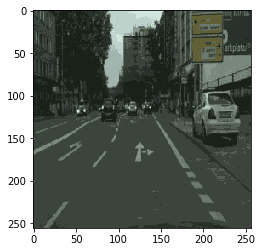

In [11]:
k = 12
attempts = 10
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)

centers = np.uint8(centers)
labels = labels.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(base.shape)
plt.imshow(segmented_image)
plt.show()

<h2>Calculate accuracy of Kmeans with ground_truth image</h2>

In [12]:
masked_image = np.copy(base)
masked_image = masked_image.reshape((-1, 3))
true_mask = np.zeros((13,65536,3))
for i in range(13):
    truth = np.copy(ground_truth)
    truth = truth.reshape((-1, 3))
    truth[truth[:,1] != (i+1)*10] = [0, 0, 0]
    truth[truth[:,1] == (i+1)*10] = [1, 1, 1]
    true_mask[i,:,:] = truth
accuracy = 0
for cluster in range(12):
    masked_image[labels != cluster] = [0, 0, 0]
    masked_image[labels == cluster] = [1, 1, 1]
    Max = 0
    max_inex = 0
    for i in range(12):
        Sum = (np.sum(true_mask[i]*masked_image))/3
        if Sum>Max:
            Max = Sum
            max_index = i
    accuracy = accuracy + Max
accuracy = accuracy + (np.sum(true_mask[12])/3)
accuracy = accuracy / (256*256)
print(accuracy)
#masked_image = masked_image.reshape(base.shape)
#plt.imshow(masked_image)
#plt.show()
#plt.imshow(true_mask[max_index].reshape(base.shape))
#plt.show()

0.641693115234375


<h2>Use Fuzzy Cmeans</h2>

In [13]:
import skfuzzy as fuzz
# params
n_centers = 12
fuzziness_degree = 2
error = 0.005
maxiter = 1000
I = pixel_values.T
# fuzz c-means clustering
centers, u, u0, d, jm, n_iters, fpc = fuzz.cluster.cmeans(
    I,
    c=n_centers,
    m=fuzziness_degree,
    error=error,
    maxiter=maxiter,
    init=None
)

labels = np.argmax(u, axis=0).astype('uint8')
centers = np.uint8(centers)
labels = labels.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(base.shape)
plt.imshow(segmented_image)
plt.show()
# display clusters
#print(img_clustered)
#print(centers)
#segmented_image = img_clustered.reshape(base.shape)
#plt.imshow(segmented_image)
#plt.show()

ModuleNotFoundError: No module named 'skfuzzy'

In [14]:
masked_image = np.copy(base)
masked_image = masked_image.reshape((-1, 3))
true_mask = np.zeros((13,65536,3))
for i in range(13):
    truth = np.copy(ground_truth)
    truth = truth.reshape((-1, 3))
    truth[truth[:,1] != (i+1)*10] = [0, 0, 0]
    truth[truth[:,1] == (i+1)*10] = [1, 1, 1]
    true_mask[i,:,:] = truth
accuracy = 0
for cluster in range(12):
    masked_image[labels != cluster] = [0, 0, 0]
    masked_image[labels == cluster] = [1, 1, 1]
    Max = 0
    max_inex = 0
    for i in range(12):
        Sum = (np.sum(true_mask[i]*masked_image))/3
        if Sum>Max:
            Max = Sum
            max_index = i
    accuracy = accuracy + Max
accuracy = accuracy + (np.sum(true_mask[12])/3)
accuracy = accuracy / (256*256)
print(accuracy)

0.641693115234375


<h2>Using PCA to reduce data dimension</h2>

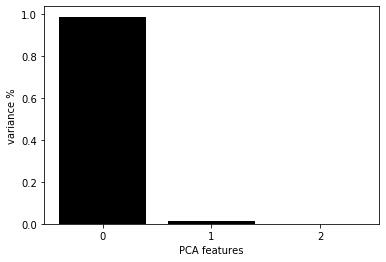

In [15]:
s=(base.reshape(-1,3))
pca = PCA()

pca.fit(s)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

#choosing 1 component between 3
pca= PCA(n_components=1)
pca.fit(s)
pca_data=pca.transform(s)

<h2>as you can see in above plot, feature 0 has high variance so we use feature 0</h2>

In [16]:
pixel_values_pca = pca_data

# convert to float
pixel_values_pca = np.float32(pixel_values_pca)

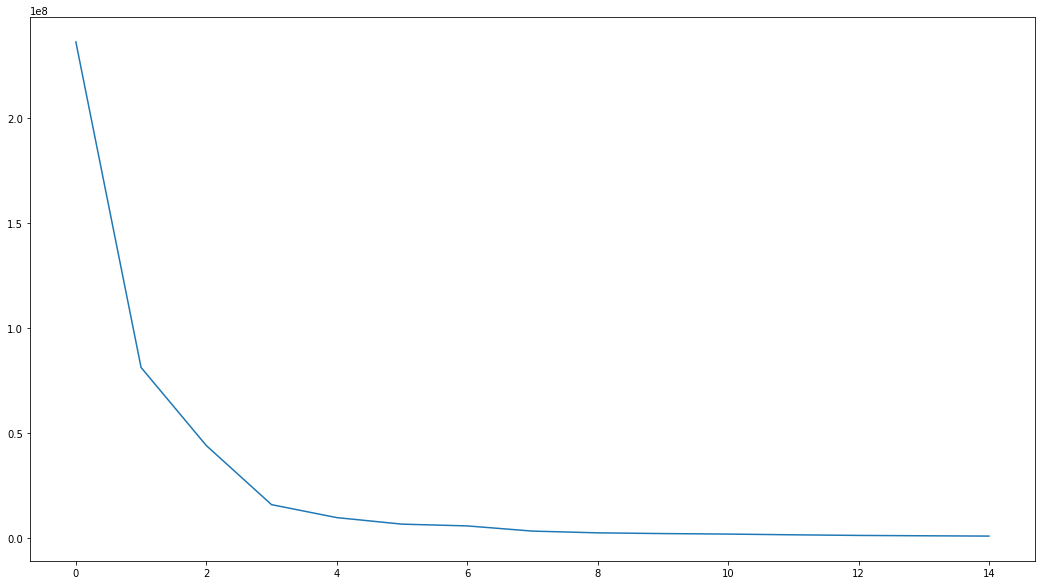

In [18]:
a = []
for k in range(15):
    sss, labels_pca, (centers_pca) = cv2.kmeans(pixel_values_pca, k+1, None, criteria, attempts,cv2.KMEANS_RANDOM_CENTERS)
    centers_pca = np.uint8(centers_pca)
    labels_pca = labels_pca.flatten()
    segmented_image_pca = centers_pca[labels_pca.flatten()]
    segmented_image_pca = segmented_image_pca.reshape(pca_data.shape)
#     temp = cv2.norm(segmented_image_pca, pca_data)
#     #what does it do? and for what?
#     avg = cv2.mean(temp)
    a.append(sss)
plt.figure(figsize=(18, 10))
plt.plot(a)
plt.show()

<h2>Choosing best number of cluster : 5</h2>

(256, 256)


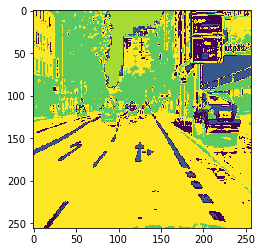

In [19]:
_, labels_pca, (centers_pca) = cv2.kmeans(pixel_values_pca, 5, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
# centers4=[
#     [0,256,256],
#     [256,0,0],
#     [0,256,0],
#     [0,0,256],
#     [100,180,180],
#     [180,100,180],
#     [180,180,100],
#     [50,100,100],
#     [100,100,50],
#     [100,50,100]
# ]
centers_pca = np.uint8(centers_pca)
labels_pca = labels_pca.flatten()
segmented_image_pca = centers_pca[labels_pca.flatten()]
segmented_image_pca = segmented_image_pca.reshape((256,256))
print(segmented_image_pca.shape)
plt.imshow(segmented_image_pca)
plt.show()

<h2>Use pyclustering library for other metric tools</h2>

In [20]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample

(256, 256, 3)


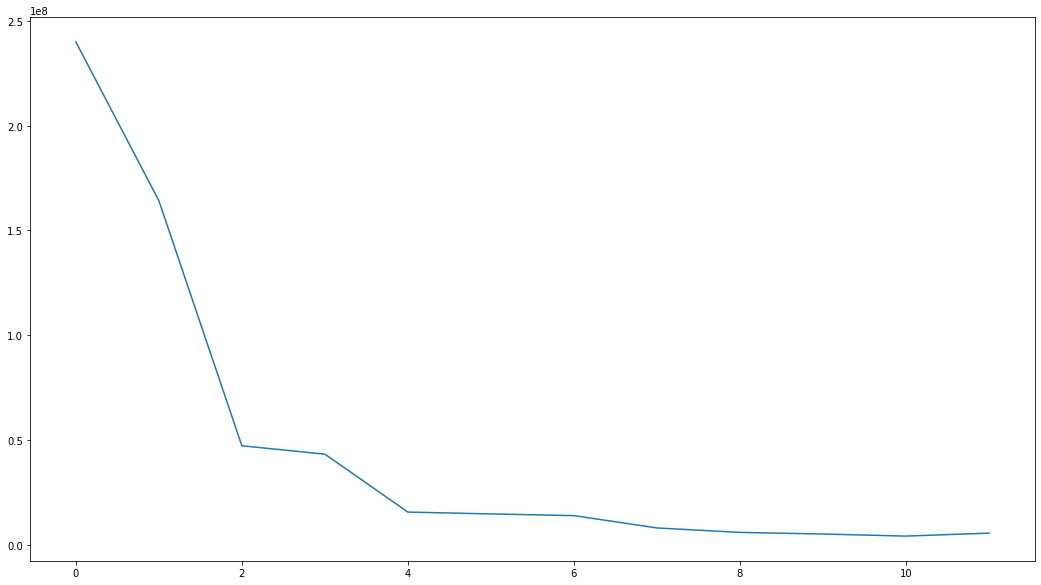

In [21]:
print(base.shape)
a=[]
for i in range(1,13):
    sss=base.reshape(-1,3)
    initial_centers = kmeans_plusplus_initializer(sss, i).initialize()
    kmeans_instance = kmeans(sss, initial_centers)
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    final_centers = kmeans_instance.get_centers()
    a.append(kmeans_instance.get_total_wce())
plt.figure(figsize=(18, 10))
plt.plot(a)
plt.show()

<h2>Choosing best number of cluster : 5</h2>

In [22]:
sss=base.reshape(-1,3)
initial_centers = kmeans_plusplus_initializer(sss, 5).initialize()
kmeans_instance = kmeans(sss, initial_centers)
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()


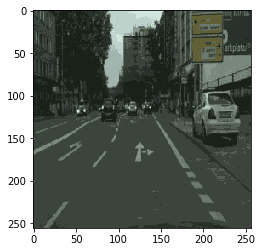

In [23]:
# print(len(final_centers))
# print(len(clusters))
for i in range(5):
    for j in clusters[i]:
        sss[j]=final_centers[i]
        
plt.imshow(segmented_image.reshape(256,256,3))
plt.show()

In [24]:
from pyclustering.utils.metric import distance_metric, type_metric

<h2>Use MANHATTAN distance</h2>

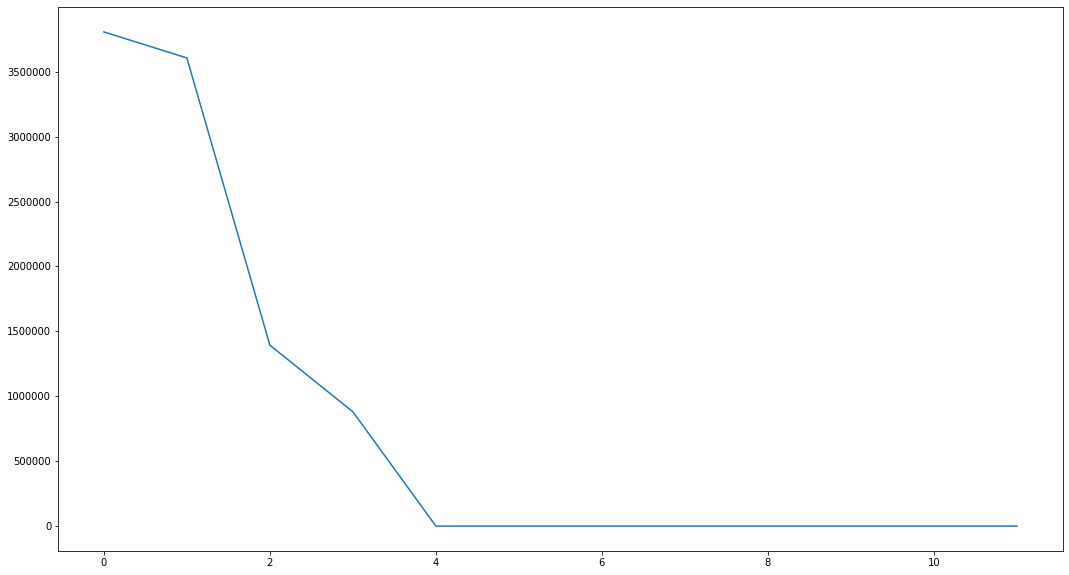

In [25]:
a=[]
manhattan_metric = distance_metric(type_metric.MANHATTAN)
for i in range(1,13):
    sss=base.reshape(-1,3)
    initial_centers = kmeans_plusplus_initializer(sss, i).initialize()
    kmeans_instance = kmeans(sss, initial_centers,metric=manhattan_metric)
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    final_centers = kmeans_instance.get_centers()
    a.append(kmeans_instance.get_total_wce())
plt.figure(figsize=(18, 10))
plt.plot(a)
plt.show()



In [26]:
sss=base.reshape(-1,3)
initial_centers = kmeans_plusplus_initializer(sss, 5).initialize()
kmeans_instance = kmeans(sss, initial_centers)
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()

5
5


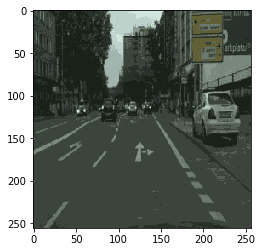

In [27]:
print(len(final_centers))
print(len(clusters))
for i in range(5):
    for j in clusters[i]:
        sss[j]=final_centers[i]
        
plt.imshow(segmented_image.reshape(256,256,3))
plt.show()

<h2> Use CHEBYSHEV distance(cosinus distance)</h2>

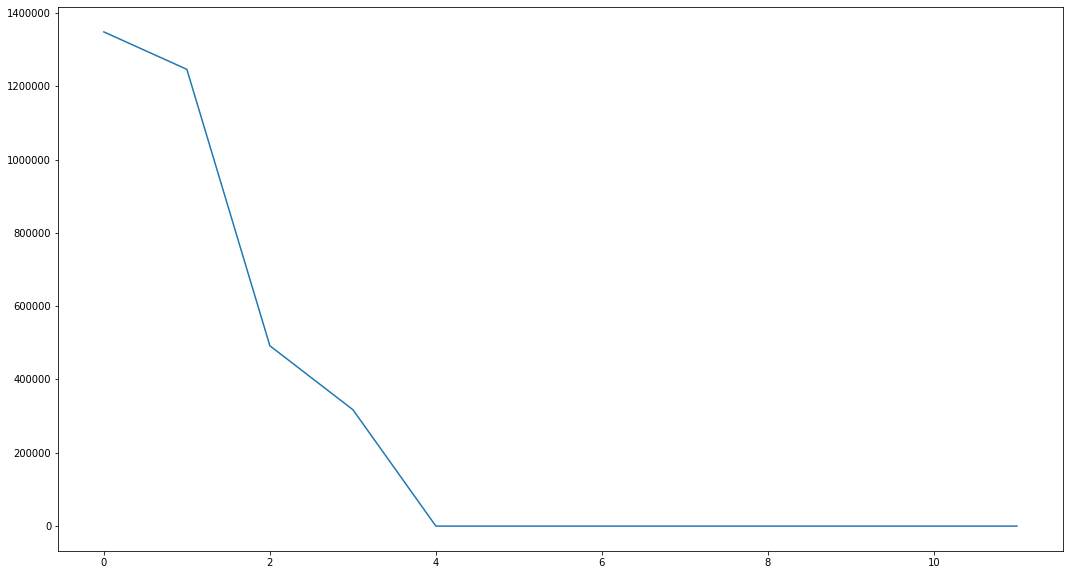

In [28]:
# chebyshev
a=[]
manhattan_metric = distance_metric(type_metric.CHEBYSHEV)
for i in range(1,13):
    sss=base.reshape(-1,3)
    initial_centers = kmeans_plusplus_initializer(sss, i).initialize()
    kmeans_instance = kmeans(sss, initial_centers,metric=manhattan_metric)
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    final_centers = kmeans_instance.get_centers()
    a.append(kmeans_instance.get_total_wce())
plt.figure(figsize=(18, 10))
plt.plot(a)
plt.show()

5
5


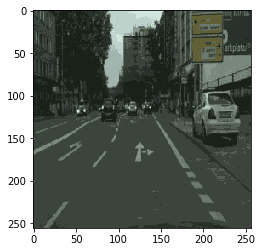

In [29]:
print(len(final_centers))
print(len(clusters))
for i in range(5):
    for j in clusters[i]:
        sss[j]=final_centers[i]
        
plt.imshow(segmented_image.reshape(256,256,3))
plt.show()